# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Introduction

In the previous notebook, we performed preliminary assessments of data quality and refined the question to be answered. We dropped many columns and some rows that were useless or had too many missing entries. We determined that predicting loan status was our primary aim. We transformed our categorical variables into numeric features, determining case by case what exactly to do, such as drop percent signs, order by ordinal value, or one-hot encode nominal values.

In this notebook we'll start to build machine learning models. Before even starting with learning a machine learning model, however, we'll start by considering how useful the mode value is as a predictor. This is more than just a pedagogical device. We never want to go to stakeholders with a machine learning model only to have the CEO point out that it performs worse than just guessing the mode! Our first model is a baseline performance comparitor for any subsequent model. We then build up the process of efficiently and robustly creating and assessing models against it. The development we lay out may be little slower than in the real world, but this step of the capstone is definitely more than just instructional. It is good practice to build up an understanding that the machine learning pipelines we build work as expected. We can validate steps with your own functions for checking expected equivalence between, say, pandas and sklearn implementations.

## 4.2 Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
# from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
# from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from library.sb_utils import save_file

## 4.3 Load Data

In [2]:
loan_data = pd.read_csv('../data/loan_data_cleaned.csv')
loan_data.head()

,loan_amnt,installment,grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months
0,5000.0,162.87,2,10,24000.0,1,27.65,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2500.0,59.83,3,0,30000.0,0,1.00,0.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2400.0,84.33,3,10,12252.0,1,8.72,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,10000.0,339.31,3,10,49200.0,1,20.00,0.0,1.0,10.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5000.0,156.46,1,3,36000.0,1,11.20,0.0,3.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
loan_data.shape

(38123, 38)

## 4.4 Train/Test Split

So far, you've treated mushroom data as a single entity. In machine learning, when you train your model on all of your data, you end up with no data set aside to evaluate model performance. You could keep making more and more complex models that fit the data better and better and not realise you were overfitting to that one set of samples. By partitioning the data into training and testing splits, without letting a model (or missing-value imputation) learn anything about the test split, you have a somewhat independent assessment of how your model might perform in the future. An often overlooked subtlety here is that people all too frequently use the test set to assess model performance _and then compare multiple models to pick the best_. This means their overall model selection process is  fitting to one specific data set, now the test split. You could keep going, trying to get better and better performance on that one data set, but that's  where cross-validation becomes especially useful. While training models, a test split is very useful as a final check on expected future performance.

What partition sizes would you have with a 70/30 train/test split?

In [4]:
len(loan_data) * .7, len(loan_data) * .3

(26686.1, 11436.9)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(loan_data.drop(columns='loan_status'), 
                                                    loan_data.loan_status, test_size=0.3, 
                                                    random_state=47)

In [6]:
X_train.shape, X_test.shape

((26686, 37), (11437, 37))

In [7]:
y_train.shape, y_test.shape

((26686,), (11437,))

In [8]:
#Code task 2#
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes.value_counts()

float64    35
int64       2
dtype: int64

In [9]:
#Code task 3#
#Repeat this check for the test split in `X_test`
X_test.dtypes.value_counts()

float64    35
int64       2
dtype: int64

You have only numeric features in your X now!

## 4.5 Initial Not-Even-A-Model

A good place to start is to see how good the mode is as a predictor. In other words, what if you simply say your best guess is the mode?

In [10]:
#Code task 4#
#Calculate the mode of `y_train`
train_mode = y_train.mode()
train_mode

0    1
dtype: int64

`sklearn`'s `DummyRegressor` easily does this (note that for binary variables, the median is an integer if and only if the mode is unique):

In [11]:
#Code task 5#
#Fit the dummy regressor on the training data
#Hint, call its `.fit()` method with `X_train` and `y_train` as arguments
#Then print the object's `constant_` attribute and verify it's the same as the mode above
dumb_reg = DummyRegressor(strategy='median')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[1.]])

How good is this? How closely does this match, or explain, the actual values? There are many ways of assessing how good one set of values agrees with another, which brings us to the subject of metrics.

### 4.5.1 Metrics

#### 4.5.1.1 Balanced accuracy (average of recall for each class)

One measure is balanced accuracy. This is the average of recall for each of the classes of the target feature.

In [12]:
from sklearn.metrics import balanced_accuracy_score

Make your predictions by creating an array of length the size of the training set with the single value of the mode.

In [13]:
y_tr_pred_ = float(train_mode) * np.ones(len(y_train))
y_tr_pred_[:5]

array([1., 1., 1., 1., 1.])

Remember the `sklearn` dummy regressor? 

In [14]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([1., 1., 1., 1., 1.])

You can see that `DummyRegressor` produces exactly the same results and saves you having to mess about broadcasting the median (or whichever other statistic we used - check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) to see what's available) to an array of the appropriate length. It also gives you an object with `fit()` and `predict()` methods as well so you can use them as conveniently as any other `sklearn` estimator.

In [15]:
balanced_accuracy_score(y_train, y_tr_pred)

0.5

As expected, the balanced accuracy score is abysmal. Our dataset is imbalanced, and this regressor will miss all the charged off loans which, for practical business purposes, is very bad. What if you use this "model" to predict unseen values from the test set? Remember, of course, that your "model" is trained on the training set; you still use the training set mode as your prediction.

Make your predictions by creating an array of length the size of the test set with the single value of the (training) mode.

In [16]:
y_te_pred = float(train_mode) * np.ones(len(y_test))
balanced_accuracy_score(y_test, y_te_pred)

0.5

Generally, you can expect performance on a test set to be slightly worse than on the training set.

In [17]:
from sklearn.metrics import classification_report

In [18]:
print(classification_report(y_train, y_tr_pred, target_names=['charged off','fully paid']))

              precision    recall  f1-score   support

 charged off       0.00      0.00      0.00      3799
  fully paid       0.86      1.00      0.92     22887

    accuracy                           0.86     26686
   macro avg       0.43      0.50      0.46     26686
weighted avg       0.74      0.86      0.79     26686



/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
print(classification_report(y_test, y_te_pred, target_names=['charged off','fully paid']))

              precision    recall  f1-score   support

 charged off       0.00      0.00      0.00      1607
  fully paid       0.86      1.00      0.92      9830

    accuracy                           0.86     11437
   macro avg       0.43      0.50      0.46     11437
weighted avg       0.74      0.86      0.79     11437



/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The dummy regressor always classifies everything as edible since that's the mode class. Consequently, precision and recall for the poisonous class is undefined.

### 4.5.2 Note On Calculating Metrics

When calling functions to calculate metrics, it is important to take care in the order of the arguments. One of the metrics above actually doesn't care if the arguments are reversed; the rest do. Which ones care?

In a Jupyter code cell, running `balanced_accuracy_score?` will bring up the docstring for the function, and `balanced_accuracy_score??` will bring up the actual code of the function! Try them and compare the source for `sklearn`'s function with yours. Feel free to explore what happens when you reverse the order of the arguments and compare behaviour of `sklearn`'s function and yours.

In [20]:
# train set - accuracy
# correct order, incorrect order
balanced_accuracy_score(y_train, y_tr_pred), balanced_accuracy_score(y_tr_pred, y_train)

/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(0.5, 0.8576407104848984)

In [21]:
# test set - accuracy
# correct order, incorrect order
balanced_accuracy_score(y_test, y_te_pred), balanced_accuracy_score(y_te_pred, y_test)

/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(0.5, 0.8594911252950949)

In [22]:
# train set - precision, recall, F1 score
print(classification_report(y_train, y_tr_pred, target_names=['charged off','fully paid'])) 
print(classification_report(y_tr_pred, y_train, target_names=['charged off','fully paid']))

/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 charged off       0.00      0.00      0.00      3799
  fully paid       0.86      1.00      0.92     22887

    accuracy                           0.86     26686
   macro avg       0.43      0.50      0.46     26686
weighted avg       0.74      0.86      0.79     26686

              precision    recall  f1-score   support

 charged off       0.00      0.00      0.00         0
  fully paid       1.00      0.86      0.92     26686

    accuracy                           0.86     26686
   macro avg       0.50      0.43      0.46     26686
weighted avg       1.00      0.86      0.92     26686



/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_cla

In [23]:
# test set - precision, recall, F1 score
# correct order, incorrect order
print(classification_report(y_test, y_te_pred, target_names=['charged off','fully paid'])) 
print(classification_report(y_te_pred, y_test, target_names=['charged off','fully paid']))

              precision    recall  f1-score   support

 charged off       0.00      0.00      0.00      1607
  fully paid       0.86      1.00      0.92      9830

    accuracy                           0.86     11437
   macro avg       0.43      0.50      0.46     11437
weighted avg       0.74      0.86      0.79     11437

              precision    recall  f1-score   support

 charged off       0.00      0.00      0.00         0
  fully paid       1.00      0.86      0.92     11437

    accuracy                           0.86     11437
   macro avg       0.50      0.43      0.46     11437
weighted avg       1.00      0.86      0.92     11437



/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jim/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jim/.local/lib/python3.6/site-packages/skle

You can get very different results swapping the argument order. It's worth highlighting this because data scientists do this too much in the real world! Don't be one of them! Frequently the argument order doesn't matter, but it will bite you when you do it with a function that does care. It's sloppy, bad practice and if you don't make a habit of putting arguments in the right order, you will forget!

Remember:
* argument order matters,
* check function syntax with `func?` in a code cell

## 4.6 Initial Models

#### 4.6.1.1 Rebalance the data

As we know from our data wrangling work, the loan dataset has rather imbalanced classes. Paid off loans comprise 86\% of the dataset, whereas charged off loans comprise 14\%. We want to correct this imbalance. One way is to use SMOTE, short for Synthetic Minority Oversampling Technique, where we oversample the minority class by generating synthetic samples that interpolate between original ones. Another way is to undersample the majority class.

In [24]:
# summarize class distribution
counter = Counter(y_train)
print(counter)

Counter({1: 22887, 0: 3799})


In [25]:
from imblearn.pipeline import Pipeline
# define pipeline
over = SMOTE(sampling_strategy=0.2,random_state=47)
under = RandomUnderSampler(sampling_strategy=0.8,random_state=47)
steps = [('o', over), ('u', under)]
imb_pl = Pipeline(steps=steps)
# transform the dataset
X_train_rebal, y_train_rebal = imb_pl.fit_resample(X_train, y_train)

In [26]:
# summarize the new class distribution
counter = Counter(y_train_rebal)
print(counter)

Counter({1: 5721, 0: 4577})


##### 4.6.1.2 Scale the data

As you have features measured in many different units, with numbers that vary by orders of magnitude, start off by scaling them to put them all on a consistent scale. The [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) scales each feature to zero mean and unit variance.

In [27]:
#Code task 10#
#Call the StandardScaler`s fit method on `X_tr` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_train_rebal)
X_tr_scaled = scaler.transform(X_train_rebal)
X_te_scaled = scaler.transform(X_test)

##### 4.6.1.3 Train the model on the train split

In [28]:
lm = LogisticRegression(penalty='l1',random_state=47,solver='liblinear').fit(X_tr_scaled, y_train_rebal)

##### 4.6.1.4 Make predictions using the model on both train and test splits

In [29]:
#Code task 11#
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

##### 4.6.1.5 Assess model performance

In [30]:
# accuracy - train, test
scaled_balanced_accuracy = balanced_accuracy_score(y_train_rebal, y_tr_pred), balanced_accuracy_score(y_test, y_te_pred)
scaled_balanced_accuracy

(0.6435165575794738, 0.6261679731540735)

Recall that you estimated loan status by simply using the mode, a known average. As expected, this produced an accuracy score of about 86\% for both the training and test set because the dataset was imbalanced, and you were using just the mode. Here we see that our simple logistic regression model is 76\% accurate, but it may still be better in other respects.

In [31]:
#Code task 12#
#Now calculate the mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as we did above for R^2
# MAE - train, test
scaled_classification_report = classification_report(y_train_rebal, y_tr_pred, target_names=['charged off','fully paid'])+'\n'+classification_report(y_test, y_te_pred, target_names=['charged off','fully paid'])
print(scaled_classification_report)

              precision    recall  f1-score   support

 charged off       0.63      0.53      0.58      4577
  fully paid       0.67      0.75      0.71      5721

    accuracy                           0.66     10298
   macro avg       0.65      0.64      0.64     10298
weighted avg       0.65      0.66      0.65     10298

              precision    recall  f1-score   support

 charged off       0.25      0.51      0.33      1607
  fully paid       0.90      0.74      0.82      9830

    accuracy                           0.71     11437
   macro avg       0.57      0.63      0.57     11437
weighted avg       0.81      0.71      0.75     11437



Using this model, then, on average you'd expect to better predict loans that get charged off. This is much, much better than guessing using the mode. There may be something to this machine learning lark after all!

### 4.6.2 Pipelines

One of the most important and useful components of `sklearn` is the [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Remember the first logistic regression model above performed the steps:

1. scale the data to zero mean and unit variance
2. train a logistic regression model

and all these steps were trained on the train split and then applied to the test split for assessment.

The pipeline below defines exactly those same steps. Crucially, the resultant `Pipeline` object has a `fit()` method and a `predict()` method, just like the `LogisticRegression()` object itself. Just as you might create a logistic regression model and train it with `.fit()` and predict with `.predict()`, you can wrap the entire process of feature scaling and regression in a single object you can train with `.fit()` and predict with `.predict()`. And that's basically a pipeline: a model on steroids.

#### 4.6.2.1 Define the pipeline

In [32]:
pipe = make_pipeline(
    SMOTE(sampling_strategy=0.2),
    RandomUnderSampler(sampling_strategy=0.8),
    StandardScaler(),
    LogisticRegression(penalty='l1',random_state=47,solver='liblinear')
)

In [33]:
type(pipe)

imblearn.pipeline.Pipeline

In [34]:
hasattr(pipe, 'fit'), hasattr(pipe, 'predict')

(True, True)

#### 4.6.2.2 Fit the pipeline

Here, a single call to the pipeline's `fit()` method combines the steps of learning the imputation (determining what values to use to fill the missing ones), the scaling (determining the mean to subtract and the variance to divide by), and then training the model. It does this all in the one call with the training data as arguments.

In [35]:
#Code task 15#
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(sampling_strategy=0.2)),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy=0.8)),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(penalty='l1', random_state=47,
                                    solver='liblinear'))])

#### 4.6.2.3 Make predictions on the train and test sets

In [36]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

#### 4.6.2.4 Assess performance

In [37]:
balanced_accuracy_score(y_train, y_tr_pred), balanced_accuracy_score(y_test, y_te_pred)

(0.6373643433266611, 0.6278735706766113)

And compare with your earlier (non-pipeline) result:

In [38]:
scaled_balanced_accuracy

(0.6435165575794738, 0.6261679731540735)

In [39]:
print(classification_report(y_train, y_tr_pred, target_names=['charged off','fully paid']))
print(classification_report(y_test, y_te_pred, target_names=['charged off','fully paid']))

              precision    recall  f1-score   support

 charged off       0.26      0.52      0.35      3799
  fully paid       0.90      0.75      0.82     22887

    accuracy                           0.72     26686
   macro avg       0.58      0.64      0.58     26686
weighted avg       0.81      0.72      0.75     26686

              precision    recall  f1-score   support

 charged off       0.25      0.51      0.33      1607
  fully paid       0.90      0.75      0.82      9830

    accuracy                           0.72     11437
   macro avg       0.58      0.63      0.58     11437
weighted avg       0.81      0.72      0.75     11437



Compare with your earlier result:

In [40]:
print(scaled_classification_report)

              precision    recall  f1-score   support

 charged off       0.63      0.53      0.58      4577
  fully paid       0.67      0.75      0.71      5721

    accuracy                           0.66     10298
   macro avg       0.65      0.64      0.64     10298
weighted avg       0.65      0.66      0.65     10298

              precision    recall  f1-score   support

 charged off       0.25      0.51      0.33      1607
  fully paid       0.90      0.74      0.82      9830

    accuracy                           0.71     11437
   macro avg       0.57      0.63      0.57     11437
weighted avg       0.81      0.71      0.75     11437



These results confirm the pipeline is doing exactly what's expected, and results are identical to your earlier steps. This allows you to move faster but with confidence.

## 4.7 Refining The Logistic Regression Model<a id='4.7_Refining_The_Logistic_Regression_Model'></a>

You suspected the model was overfitting. This is no real surprise given the number of features you blindly used. It's likely a judicious subset of features would generalize better. `sklearn` has a number of feature selection functions available. The one you'll use here is `SelectKBest` which, as you might guess, selects the k best features. You can read about SelectKBest 
[here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest). `f_classif` is just the [score function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) you're using because you're performing classification. It's important to choose an appropriate one for your machine learning task.

### 4.7.1 Define the pipeline

Redefine your pipeline to include this feature selection step:

In [41]:
#Code task 16#
#Add `SelectKBest` as a step in the pipeline between `StandardScaler()` and `LogisticRegression()`
#It uses `f_classif` as its score function by default
pipe = make_pipeline(
    SMOTE(sampling_strategy=0.2,random_state=47),
    RandomUnderSampler(sampling_strategy=0.8,random_state=47),
    StandardScaler(),
    SelectKBest(),
    LogisticRegression(penalty='l1',random_state=47,solver='liblinear')
)

### 4.7.2 Fit the pipeline

In [42]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=47, sampling_strategy=0.2)),
                ('randomundersampler',
                 RandomUnderSampler(random_state=47, sampling_strategy=0.8)),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest()),
                ('logisticregression',
                 LogisticRegression(penalty='l1', random_state=47,
                                    solver='liblinear'))])

### 4.7.3 Assess performance on the train and test set

In [43]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [44]:
balanced_accuracy_score(y_train, y_tr_pred), balanced_accuracy_score(y_test, y_te_pred)

(0.6373249288339533, 0.626087355611671)

In [45]:
print(classification_report(y_train, y_tr_pred, target_names=['charged off','fully paid']))
print(classification_report(y_test, y_te_pred, target_names=['charged off','fully paid']))

              precision    recall  f1-score   support

 charged off       0.26      0.53      0.35      3799
  fully paid       0.90      0.75      0.82     22887

    accuracy                           0.72     26686
   macro avg       0.58      0.64      0.58     26686
weighted avg       0.81      0.72      0.75     26686

              precision    recall  f1-score   support

 charged off       0.25      0.50      0.33      1607
  fully paid       0.90      0.75      0.82      9830

    accuracy                           0.71     11437
   macro avg       0.57      0.63      0.57     11437
weighted avg       0.81      0.71      0.75     11437



This has made things worse! Clearly selecting a subset of features has an impact on performance. `SelectKBest` defaults to k=10. You've just seen that 10 is worse than using all features. What is the best k? You could create a new pipeline with a different value of k:

### 4.7.4 Define a new pipeline to select a different number of features

In [46]:
#Code task 17#
#Modify the `SelectKBest` step to use a value of 15 for k
pipe15 = make_pipeline(
    SMOTE(sampling_strategy=0.2,random_state=47),
    RandomUnderSampler(sampling_strategy=0.8,random_state=47),
    StandardScaler(),
    SelectKBest(k=15),
    LogisticRegression(penalty='l1',random_state=47,solver='liblinear')
)

### 4.7.5 Fit the pipeline

In [47]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=47, sampling_strategy=0.2)),
                ('randomundersampler',
                 RandomUnderSampler(random_state=47, sampling_strategy=0.8)),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=15)),
                ('logisticregression',
                 LogisticRegression(penalty='l1', random_state=47,
                                    solver='liblinear'))])

### 4.7.6 Assess performance on train and test data

In [48]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [49]:
balanced_accuracy_score(y_train, y_tr_pred), balanced_accuracy_score(y_test, y_te_pred)

(0.6373696913684205, 0.6270656860467398)

In [50]:
print(classification_report(y_train, y_tr_pred, target_names=['charged off','fully paid']))
print(classification_report(y_test, y_te_pred, target_names=['charged off','fully paid']))

              precision    recall  f1-score   support

 charged off       0.26      0.53      0.35      3799
  fully paid       0.90      0.75      0.82     22887

    accuracy                           0.72     26686
   macro avg       0.58      0.64      0.58     26686
weighted avg       0.81      0.72      0.75     26686

              precision    recall  f1-score   support

 charged off       0.25      0.51      0.33      1607
  fully paid       0.90      0.75      0.82      9830

    accuracy                           0.71     11437
   macro avg       0.57      0.63      0.58     11437
weighted avg       0.81      0.71      0.75     11437



You could keep going, trying different values of k, training a model, measuring performance on the test set, and then picking the model with the best test set performance. There's a fundamental problem with this approach: _you're tuning the model to the arbitrary test set_! If you continue this way you'll end up with a model works well on the particular quirks of our test set _but fails to generalize to new data_. The whole point of keeping a test set is for it to be a set of that new data, to check how well our model might perform on data it hasn't seen.

The way around this is a technique called _cross-validation_. You partition the training set into k folds, train our model on k-1 of those folds, and calculate performance on the fold not used in training. This procedure then cycles through k times with a different fold held back each time. Thus you end up building k models on k sets of data with k estimates of how the model performs on unseen data but without having to touch the test set.

### 4.7.7 Assessing performance using cross-validation

In [51]:
cv_results = cross_validate(pipe15, X_train, y_train, scoring='balanced_accuracy', cv=5)

/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [15] are constant.
  UserWarning)
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [15] are constant.
  UserWarning)
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [15] are constant.
  UserWarning)
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/j

In [52]:
cv_scores = cv_results['test_score']
cv_scores

array([0.63448874, 0.64349821, 0.63947167, 0.62349792, 0.63016657])

Without using the same random state for initializing the CV folds, your actual numbers will be different.

In [53]:
np.mean(cv_scores), np.std(cv_scores)

(0.6342246222359361, 0.007001864071931818)

These results highlight that assessing model performance in inherently open to variability. You'll get different results depending on the quirks of which points are in which fold. An advantage of this is that you can also obtain an estimate of the variability, or uncertainty, in your performance estimate.

In [54]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.62, 0.65])

### 4.7.8 Hyperparameter search using GridSearchCV

Pulling the above together, we have:
* a pipeline that
    * scales the data
    * selects the k best features
    * trains a logistic regression model
* a technique (cross-validation) for estimating model performance

Now you want to use cross-validation for multiple values of k and use cross-validation to pick the value of k that gives the best performance. `make_pipeline` automatically names each step as the lowercase name of the step and the parameters of the step are then accessed by appending a double underscore followed by the parameter name. You know the name of the step will be 'selectkbest' and you know the parameter is 'k'.

You can also list the names of all the parameters in a pipeline like this:

In [55]:
#Code task 18#
#Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
#using dict's `keys()` method
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'smote', 'randomundersampler', 'standardscaler', 'selectkbest', 'logisticregression', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

The above can be particularly useful as your pipelines becomes more complex (you can even nest pipelines within pipelines).

In [56]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

Now you have a range of `k` to investigate. Is 1 feature best? 2? 3? 4? All of them? You could write a for loop and iterate over each possible value, doing all the housekeeping oyurselves to track the best value of k. But this is  a common task so there's a built in function in `sklearn`. This is [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
This takes the pipeline object, in fact it takes anything with a `.fit()` and `.predict()` method. In simple cases with no feature selection or imputation or feature scaling etc. you may see the classifier or regressor object itself directly passed into `GridSearchCV`. The other key input is the parameters and values to search over. Optional parameters include the cross-validation strategy and number of CPUs to use.

In [57]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, scoring='balanced_accuracy', n_jobs=-1)

In [58]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=47,
                                              sampling_strategy=0.2)),
                                       ('randomundersampler',
                                        RandomUnderSampler(random_state=47,
                                                           sampling_strategy=0.8)),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression(penalty='l1',
                                                           random_state=47,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                               

In [59]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [60]:
#Code task 19#
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 33}

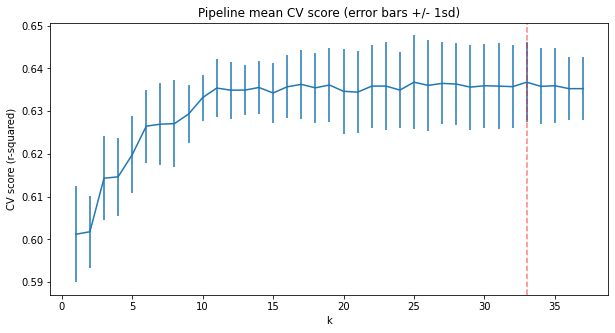

In [61]:
#Code task 20#
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good value for k is 33.

Which features were most useful? Step into your best model, shown below. Starting with the fitted grid search object, you get the best estimator, then the named step 'selectkbest', for which you can its `get_support()` method for a logical mask of the features selected.

In [62]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

Similarly, instead of using the 'selectkbest' named step, you can access the named step for the logistic regression model and, from that, grab the model coefficients via its `coef_` attribute:

In [63]:
#Code task 21#
#Get the logistic regression model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.logisticregression.coef_
features = X_train.columns[selected]
pd.Series(coefs[0], index=features).sort_values(ascending=False)

mean_fico                           0.378308
annual_inc                          0.288602
purpose_credit_card                 0.179052
purpose_debt_consolidation          0.129990
purpose_car                         0.083845
home_ownership_MORTGAGE             0.054941
purpose_major_purchase              0.044145
purpose_wedding                     0.042346
purpose_home_improvement            0.040300
home_ownership_NONE                 0.036404
delinq_2yrs                         0.036278
dti                                 0.025566
home_ownership_RENT                 0.016410
total_acc                           0.014905
purpose_vacation                    0.003544
home_ownership_OWN                  0.000000
installment                        -0.000643
purpose_house                      -0.003841
open_acc                           -0.015350
purpose_other                      -0.018322
purpose_medical                    -0.021748
verification_status_Not Verified   -0.024154
verificati

These results suggest that people with good FICO scores or high annual income are very likely to fully pay off their loans. This makes intuitive sense because they have a better reputation for making loan payments on time or more money readily available to pay their loans. Also, you see that longer term loans are less likely to be fully paid, which makes sense because financial circumstances can change over time. Borrowers with credit inquiries in the last 6 months are much less likely to fully pay their loans, possibly because lenders don't see them as trustworthy borrowers and they are desperate.

## 4.8 Random Forest Model

A model that can work very well in a lot of cases is the random forest. For classification, this is provided by `sklearn`'s `RandomForestClassifier` class.

### 4.8.1 Define the pipeline

In [64]:
#Code task 22#
#Define a pipeline comprising the steps:
#StandardScaler(),
#and RandomForestClassifier() with a random state of 47
RF_pipe = make_pipeline(
    SMOTE(sampling_strategy=0.2,random_state=47),
    RandomUnderSampler(sampling_strategy=0.8,random_state=47),
    StandardScaler(),
    RandomForestClassifier(random_state=47)
)

### 4.8.2 Fit and assess performance using cross-validation

In [65]:
#Code task 23#
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, scoring='balanced_accuracy', cv=5)

In [66]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.61977076, 0.63050688, 0.60260757, 0.60329479, 0.62990654])

In [67]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.6172173079053027, 0.012259119771434434)

### 4.8.3 Hyperparameter search using GridSearchCV

Random forest has a number of hyperparameters that can be explored, however here you'll limit yourselves to exploring some different values for the number of trees. You'll try it with and without feature scaling, and try both the mean and median as strategies for imputing missing values.

In [68]:
n_est = [int(n) for n in range(1,51)]
grid_params = {
        'randomforestclassifier__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestclassifier__n_estimators': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 'standardscaler': [StandardScaler(), None]}

In [69]:
#Code task 24#
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, scoring='balanced_accuracy', n_jobs=-1)

In [70]:
#Code task 25#
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=47,
                                              sampling_strategy=0.2)),
                                       ('randomundersampler',
                                        RandomUnderSampler(random_state=47,
                                                           sampling_strategy=0.8)),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__n_estimators': [1, 2, 3, 4, 5,
                                                                  6, 7, 8, 9,
                                                                  10, 11, 12,
                                                                  13, 14, 15,
          

In [71]:
#Code task 26#
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestclassifier__n_estimators': 44, 'standardscaler': None}

It looks like scaling the features does not help.

In [72]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, scoring='balanced_accuracy', cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.6234241 , 0.62451025, 0.61029849, 0.61581923, 0.62028348])

In [73]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.6188671088740574, 0.005240765129500868)

You've marginally improved upon the default CV results. Random forest has many more hyperparameters you could tune, but we won't dive into that here.

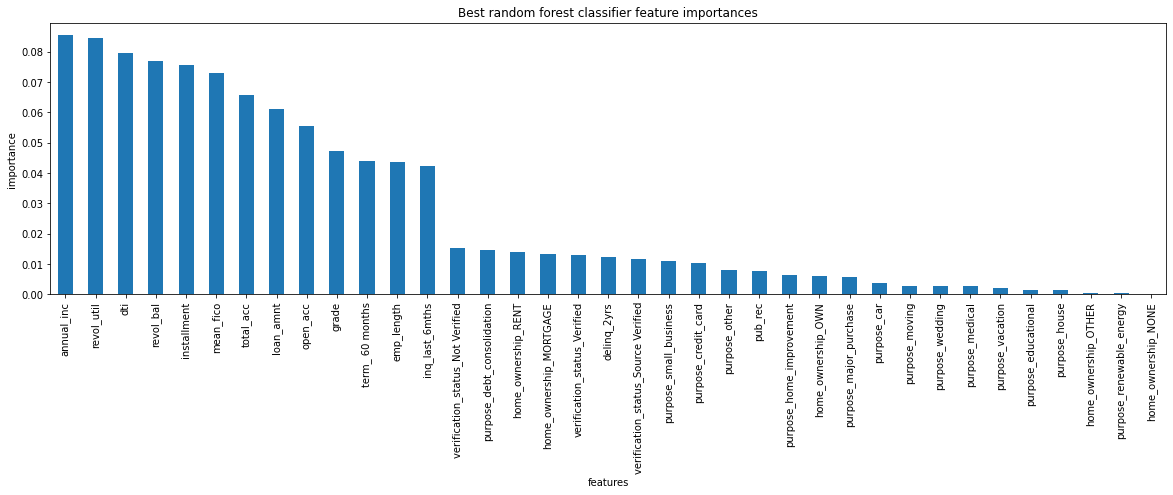

In [74]:
#Code task 27#
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestclassifier` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

The dominant top four features are also important in your logistic regression model:
* `annual_inc` (annual income)
* `revol_util` (credit utilization)
* `dti` (monthly debt to income)
* `revol_bal` (total credit balance)

## 4.9 XGBoost

A model that can work very well in a lot of cases is XGBoost. For classification, this is provided by `xgboost`'s `XGBClassifier` class.

### 4.9.1 Define the pipeline

In [75]:
#Code task 22#
#Define a pipeline comprising the steps:
#StandardScaler(),
#and XGBClassifier() with a random state of 47
XGB_pipe = make_pipeline(
    SMOTE(sampling_strategy=0.2,random_state=47),
    RandomUnderSampler(sampling_strategy=0.8,random_state=47),
    StandardScaler(),
    XGBClassifier(random_state=47)
)

### 4.9.2 Fit and assess performance using cross-validation

In [76]:
#Code task 23#
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the XGBoost pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
xgb_default_cv_results = cross_validate(XGB_pipe, X_train, y_train, scoring='balanced_accuracy', cv=5)

/home/jim/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jim/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jim/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jim/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jim/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [77]:
xgb_cv_scores = xgb_default_cv_results['test_score']
xgb_cv_scores

array([0.62528081, 0.61264908, 0.60472227, 0.59246274, 0.59969714])

In [78]:
np.mean(xgb_cv_scores), np.std(xgb_cv_scores)

(0.6069624081962166, 0.011277806459364378)

### 4.9.3 Hyperparameter search using GridSearchCV

Random forest has a number of hyperparameters that can be explored, however here you'll limit yourselves to exploring some different values for the number of trees. You'll try it with and without feature scaling, and try both the mean and median as strategies for imputing missing values.

In [79]:
n_est = [int(n) for n in range(1,21)]
grid_params = {
        'xgbclassifier__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'xgbclassifier__n_estimators': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 'standardscaler': [StandardScaler(), None]}

In [80]:
#Code task 24#
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
xgb_grid_cv = GridSearchCV(XGB_pipe, param_grid=grid_params, cv=5, scoring='balanced_accuracy', n_jobs=-1)

In [81]:
#Code task 25#
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
xgb_grid_cv.fit(X_train, y_train)

[23:26:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jim/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=47,
                                              sampling_strategy=0.2)),
                                       ('randomundersampler',
                                        RandomUnderSampler(random_state=47,
                                                           sampling_strategy=0.8)),
                                       ('standardscaler', StandardScaler()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=N...
      

In [82]:
#Code task 26#
#Print the best params (`best_params_` attribute) from the grid search
xgb_grid_cv.best_params_

{'standardscaler': None, 'xgbclassifier__n_estimators': 18}

It looks like scaling the features does not help.

In [83]:
xgb_best_cv_results = cross_validate(xgb_grid_cv.best_estimator_, X_train, y_train, scoring='balanced_accuracy', cv=5)
xgb_best_scores = xgb_best_cv_results['test_score']
xgb_best_scores

/home/jim/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jim/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jim/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jim/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jim/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


array([0.61920656, 0.63375233, 0.62123489, 0.62280093, 0.61467794])

In [84]:
np.mean(xgb_best_scores), np.std(xgb_best_scores)

(0.6223345313192353, 0.006327725758734495)

You've marginally improved upon the default CV results. XGB has many more hyperparameters you could tune, but we won't dive into that here.

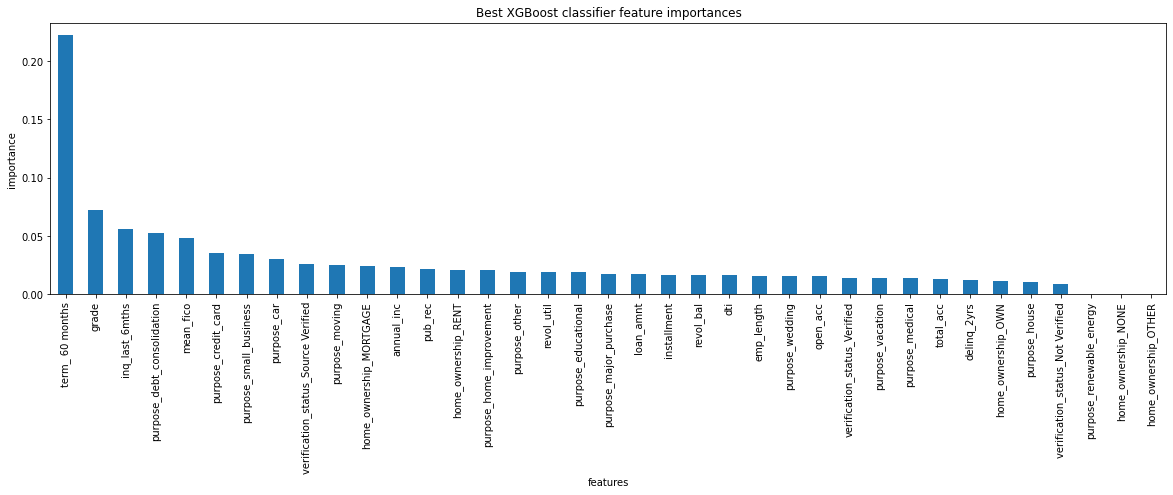

In [85]:
#Code task 27#
#Plot a barplot of the XGBoost's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.xgbclassifier` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 5))
imps = xgb_grid_cv.best_estimator_.named_steps.xgbclassifier.feature_importances_
xgb_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
xgb_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best XGBoost classifier feature importances');

The dominant top four features are also important in your logistic regression model:
* `term_60 months` (length of loan requested)
* `grade` (measure of the quality of a loan)
* `inq_last_6mths` (credit inquiries in the last 6 months)
* `purpose_debt_consolidation` (whether the purpose of the loan is for debt consolidation)

## 4.10 One Class SVM

A model that can work well with linearly separable data with unbalanced classes is one class support vector machines. This is provided by sklearn's OneClassSVM class.

### 4.10.1 Define the pipeline

In [86]:
#Code task 22#
#Define a pipeline comprising the steps:
#StandardScaler()
#and OneClassSVM()
OCSVM_pipe = make_pipeline(
    StandardScaler(),
    OneClassSVM(kernel='rbf')
)

### 4.10.2 Fit and assess performance using cross-validation

In [87]:
#Code task 23#
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the one class svm pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
ocsvm_default_cv_results = cross_validate(OCSVM_pipe, X_train, 2*y_train-1, scoring='balanced_accuracy', cv=5)

In [88]:
ocsvm_cv_scores = ocsvm_default_cv_results['test_score']
ocsvm_cv_scores

array([0.54024618, 0.53073779, 0.54103854, 0.51916522, 0.53093731])

In [89]:
np.mean(ocsvm_cv_scores), np.std(ocsvm_cv_scores)

(0.5324250093627455, 0.007952932344181492)

### 4.10.3 Hyperparameter search using GridSearchCV

OneClassSVM has a number of hyperparameters that can be explored. They are as follows:

In [90]:
#Code task 18#
#Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
#using dict's `keys()` method
OCSVM_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'oneclasssvm', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'oneclasssvm__cache_size', 'oneclasssvm__coef0', 'oneclasssvm__degree', 'oneclasssvm__gamma', 'oneclasssvm__kernel', 'oneclasssvm__max_iter', 'oneclasssvm__nu', 'oneclasssvm__shrinking', 'oneclasssvm__tol', 'oneclasssvm__verbose'])

However, here you'll limit yourselves to exploring some different values for the value of nu. You'll try it with and without feature scaling.

In [91]:
nu_reg = [(7-n)/10 for n in range(0,5)]
grid_params = {
        'standardscaler': [StandardScaler(), None],
        'oneclasssvm__nu': nu_reg
}
grid_params

{'standardscaler': [StandardScaler(), None],
 'oneclasssvm__nu': [0.7, 0.6, 0.5, 0.4, 0.3]}

In [92]:
#Code task 24#
#Call `GridSearchCV` with the one class SVM pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
ocsvm_grid_cv = GridSearchCV(OCSVM_pipe, param_grid=grid_params, scoring='balanced_accuracy', cv=5, n_jobs=-1)

In [93]:
#Code task 25#
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
ocsvm_grid_cv.fit(X_train, 2*y_train-1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('oneclasssvm', OneClassSVM())]),
             n_jobs=-1,
             param_grid={'oneclasssvm__nu': [0.7, 0.6, 0.5, 0.4, 0.3],
                         'standardscaler': [StandardScaler(), None]},
             scoring='balanced_accuracy')

In [94]:
#Code task 26#
#Print the best params (`best_params_` attribute) from the grid search
ocsvm_grid_cv.best_params_

{'oneclasssvm__nu': 0.4, 'standardscaler': StandardScaler()}

It looks like scaling the features does not help.

In [95]:
ocsvm_best_cv_results = cross_validate(ocsvm_grid_cv.best_estimator_, X_train, 2*y_train-1, scoring='balanced_accuracy', cv=5)
ocsvm_best_scores = ocsvm_best_cv_results['test_score']
ocsvm_best_scores

array([0.54153856, 0.52707981, 0.54169428, 0.52006213, 0.53869217])

In [96]:
np.mean(ocsvm_best_scores), np.std(ocsvm_best_scores)

(0.5338133903212376, 0.008718115074977717)

## 4.11 Final Model Selection<a id='4.11_Final_Model_Selection'></a>

### 4.11.1 Logistic regression model performance<a id='4.11.1_Logistic_regression_model_performance'></a>

In [97]:
# 'balanced_accuracy' uses the balanced accuracy score
lr_bas = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='balanced_accuracy', cv=5, n_jobs=-1)

In [98]:
lr_bas_mean = np.mean(lr_bas['test_score'])
lr_bas_std = np.std(lr_bas['test_score'])
lr_bas_mean, lr_bas_std

(0.6367567727621545, 0.009352331657563167)

In [99]:
print(classification_report(y_test, lr_grid_cv.best_estimator_.predict(X_test), target_names=['charged off','fully paid']))

              precision    recall  f1-score   support

 charged off       0.25      0.51      0.33      1607
  fully paid       0.90      0.74      0.82      9830

    accuracy                           0.71     11437
   macro avg       0.57      0.63      0.57     11437
weighted avg       0.81      0.71      0.75     11437



### 4.11.2 Random forest classifier model performance

In [100]:
# 'balanced_accuracy' uses the balanced accuracy score
rf_bas = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='balanced_accuracy', cv=5, n_jobs=-1)

In [101]:
rf_bas_mean = np.mean(rf_bas['test_score'])
rf_bas_std = np.std(rf_bas['test_score'])
rf_bas_mean, rf_bas_std

(0.6188671088740574, 0.005240765129500868)

In [102]:
print(classification_report(y_test, rf_grid_cv.best_estimator_.predict(X_test), target_names=['charged off','fully paid']))

              precision    recall  f1-score   support

 charged off       0.23      0.48      0.31      1607
  fully paid       0.90      0.75      0.81      9830

    accuracy                           0.71     11437
   macro avg       0.57      0.61      0.56     11437
weighted avg       0.80      0.71      0.74     11437



### 4.11.3 XGBoost classifier model performance

In [103]:
# 'balanced_accuracy' uses the balanced accuracy score
xgb_bas = cross_validate(xgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='balanced_accuracy', cv=5, n_jobs=-1)

In [104]:
xgb_bas_mean = np.mean(xgb_bas['test_score'])
xgb_bas_std = np.std(xgb_bas['test_score'])
xgb_bas_mean, xgb_bas_std

(0.6223345313192353, 0.006327725758734495)

In [105]:
print(classification_report(y_test, xgb_grid_cv.best_estimator_.predict(X_test), target_names=['charged off','fully paid']))

              precision    recall  f1-score   support

 charged off       0.25      0.48      0.33      1607
  fully paid       0.90      0.77      0.83      9830

    accuracy                           0.73     11437
   macro avg       0.58      0.62      0.58     11437
weighted avg       0.81      0.73      0.76     11437



### 4.11.4 OneClassSVM model performance

In [106]:
# 'balanced_accuracy' uses the balanced accuracy score
ocsvm_bas = cross_validate(ocsvm_grid_cv.best_estimator_, X_train, 2*y_train-1, 
                            scoring='balanced_accuracy', cv=5, n_jobs=-1)

In [107]:
ocsvm_bas_mean = np.mean(ocsvm_bas['test_score'])
ocsvm_bas_std = np.std(ocsvm_bas['test_score'])
ocsvm_bas_mean, ocsvm_bas_std

(0.5338133903212376, 0.008718115074977717)

In [108]:
print(classification_report(2*y_test-1, ocsvm_grid_cv.best_estimator_.predict(X_test), target_names=['charged off','fully paid']))

              precision    recall  f1-score   support

 charged off       0.15      0.45      0.23      1607
  fully paid       0.87      0.60      0.71      9830

    accuracy                           0.58     11437
   macro avg       0.51      0.52      0.47     11437
weighted avg       0.77      0.58      0.64     11437



### 4.11.5 Conclusion

All models have roughly the same cross-validation mean absolute error. They also exhibit little variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

## 4.12 Data quantity assessment

Finally, you need to advise the lender whether it needs to undertake further data collection. Would more data be useful? We're often led to believe more data is always good, but gathering data invariably has a cost associated with it. Assess this trade off by seeing how performance varies with differing data set sizes. The `learning_curve` function does this conveniently.

In [109]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(lr_grid_cv.best_estimator_, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [15] are constant.
  UserWarning)
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [15] are constant.
  UserWarning)
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [15] are constant.
  UserWarning)
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/j

/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [15] are constant.
  UserWarning)
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [15] are constant.
  UserWarning)
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [15] are constant.
  UserWarning)
/home/jim/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/j

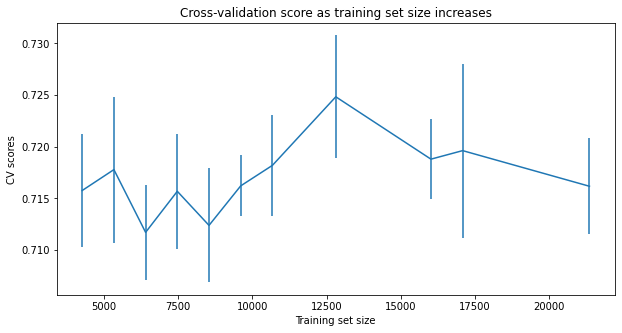

In [110]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

This shows that you seem to have plenty of data. There's an initial rapid improvement in model scores as one would expect, but it eventually levels off by around a training set size of 12000.

## 4.13 Save best model object from pipeline<a id='4.13_Save_best_model_object_from_pipeline'></a>

In [111]:
#Code task 28#
#This may not be "production grade ML deployment" practice, but adding some basic
#information to your saved models can save your bacon in development.
#Just what version model have you just loaded to reuse? What version of `sklearn`
#created it? When did you make it?
#Assign the pandas version number (`pd.__version__`) to the `pandas_version` attribute,
#the numpy version (`np.__version__`) to the `numpy_version` attribute,
#the sklearn version (`sklearn_version`) to the `sklearn_version` attribute,
#and the current datetime (`datetime.datetime.now()`) to the `build_datetime` attribute
#Let's call this model version '1.0'
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [112]:
# save the model

modelpath = '../models'
save_file(best_model, 'loan_status_model.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../models/loan_status_model.pkl"


## 4.14 Summary<a id='4.14_Summary'></a>

First, we checked what would happen if we just took the mode, and the performance on the test set was as expected, with an abysmal balanced accuracy score. There was a training balanced accuracy of 50\% and a testing balanced accuracy of 50\%.

Then we built a logistic regression model by oversampling the minority class, undersampling the majority class, scaling the data and applying logistic regression. Our initial results on the test set were very good. We refined our model, modifying our pipeline to select the k best features, cross validate, and optimize with respect to k. We found that it was optimal to use the k=33 best features. Features that made a borrower more likely to fully pay a loan included high fico score and high annual income. Features that made a borrower less likely to fully pay a loan included longer terms for the loan as well as credit inquiries within the last 6 months. The balanced accuracy from cross validation was 64\%, and the balanced accuracy on the test split was 63\%. The performance on the test split was consistent with the performance from cross-validation.

Next, we tried a random forest classifier model, with an initial pipeline consisting of oversampling the minority class, undersampling the majority class, scaling the data, and applying random forest classification. We did a hyperparameter search, with various numbers of trees and the option of scaling or not scaling the data. We found that it was optimal to use 44 trees but not scale the data. The four most important features were annual income, credit utilization, monthly debt to income ratio, and total credit balance. The balanced accuracy from cross validation was 62\%, and the balanced accuracy on the test split was 61\%. The performance on the test split was consistent with the performance from cross-validation.

Then we tried an XGBoost classifier model, with an initial pipeline consisting of oversampling the minority class, undersampling the majority class, scaling the data, and applying XGBoost classification. We did a hyperparameter search, with various numbers of trees and the option of scaling or not scaling the data. We found that it was optimal to use 18 trees but not scale the data. The four most important features were length of loan requested,
loan grade, credit inquiries in the last 6 months, and whether the purpose of the loan was for debt consolidation. The balanced accuracy from cross validation was 62\%, and the balanced accuracy on the test split was also 62\%. The performance on the test split was consistent with the performance from cross-validation.

Last but also actually least we tried a OneClassSVM model, with an initial pipeline consisting of scaling the data and applying OneClassSVM. We did a hyperparameter search, with different values of nu and the option of scaling or not scaling the data. We found that it was optimal to use nu equal to 0.4 and to scale the data. The balanced accuracy from cross validation was 53\%, and the balanced accuracy on the test split was 52\%. The performance on the test split was consistent with the performance from cross-validation.

Going forwards, the logistic regression model would be the best to use because it is simplest, most accurate, and easiest to export with the model coefficients.